# Stock Market Price Predicting with LSTM 
## By Kevin Sukher

For this project we are predicting stock market prices using a Recurrent Neural Network (RNN) technique called Long Short-Term Memory (LSTM). This program consists of taking the closing price data of a stock market data set and processing it through an LSTM model in hopes of generating an accurate prediction model of the given data. We will build the LSTM model architecture and have it train, test and predict prices based on the closing price data set input that will be split and normalized for the model beforehand.

## Preliminary Installations

Before getting started, there are a couple of libraries and packages that need to, if not already, be installed for the RNN.
* Tensorflow, a library that focuses on training and inference of deep neural networks. This can be installed with the command,
    
    `!pip install tensorflow`


* Keras, a deep learning API that runs on top of TensorFlow and is used for solving machine learning problems. This can be installed with the command,

    `!pip install keras`
    

* Pandas-Datareader, a package of the pandas library that reads and imports data based on various sources and variables. This can be installed with the command,

    `!pip install pandas-datareader`

## Importing Libraries

Importing and setting variables from the required packages. These include `numpy`, `pandas`, and `matplotlib` that provide high-level mathematical functions, data manipulation and the ability to plot similiar to the MatlLAB functionalities. As well as, `keras` for building and running machine learning RNNs.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import math
import warnings
warnings.filterwarnings('ignore')

## Obtaining and Reading Stock Data

For this project we will be using stock market data from [Yahoo Finance](https://finance.yahoo.com/), which offers downloadable historical data from most publicly traded corporations/companies.

Here the user can have the option of choosing any publicly traded company and inputting how many previous stock price `days` they want to measure for the RNN model.

As well as, choose to either use `DataReader` to get the stock data directly from the website, or download it as an `.csv` file and read it locally. For whichever path is chosen, make sure to comment out the other option.

As an example for this project, we will be looking at the previous 100 days for the prediction model.

In [2]:
days = 100

### DataReader Option for Stock Market Data

Input the `ticker` symbol of the company, the `startDate` in YYYY-MM-DD format of the stock market data, the `endDate` in YYYY-MM-DD format of the stock market data and the `nextDay` date of the end date in YYYY-MM-DD format for comparing how accurate the future day prediction of the model was to the actual next day market price.

As an example for this project, we will be using Microsoft (ticker symbol <b>MSFT</b>) for our prediction model. For the range we will look at stock market data from January 1, 2010 to January 1, 2020. The future day for prediction comparison being January 2, 2020.

In [3]:
ticker = 'MSFT'
startDate = '2010-01-01'
endDate = '2020-01-01'
nextDay = '2020-01-02'

Using `DataReader` to get data directly from [Yahoo Finance](https://finance.yahoo.com/) based on the set parameters and displaying the data table.

In [4]:
df = web.DataReader(ticker, data_source = 'yahoo', start = startDate, end = endDate)
xaxis = 'Date'
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.049969
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.057743
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,23.910097
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.661432
2010-01-08,30.879999,30.240000,30.280001,30.660000,51197400.0,23.824627
...,...,...,...,...,...,...
2019-12-24,157.710007,157.119995,157.479996,157.380005,8989200.0,155.372406
2019-12-26,158.729996,157.399994,157.559998,158.669998,14520600.0,156.645950
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,156.932251


### CSV File Option for Stock Market Data

For obtaining the `.csv` file for modeling, go to [Yahoo Finance](https://finance.yahoo.com/) and search for the company in the search bar. From there go into the <b>Historical Data</b> tab and filter for the desirable <b>time period</b> range. From there <b>download</b> the data, which Yahoo will automatically save as <b>'ticker symbol'.csv</b>. Make sure to then move it to the local path for usage.

Here we use `pd.read_csv` to read the `.csv` file and display the data table.

In [5]:
# df = pd.read_csv('MSFT.csv')
# xaxis = 'Days'
# df

Displaying the rows and columns of the data set.

In [6]:
print('Number of rows and columns in the data set: ', df.shape)

Number of rows and columns in the data set:  (2516, 6)


## Plotting the Closing Prices of the Data Set
Taking the closing day price history in the <b>Close</b> column of the data set and plotting it for visualization.

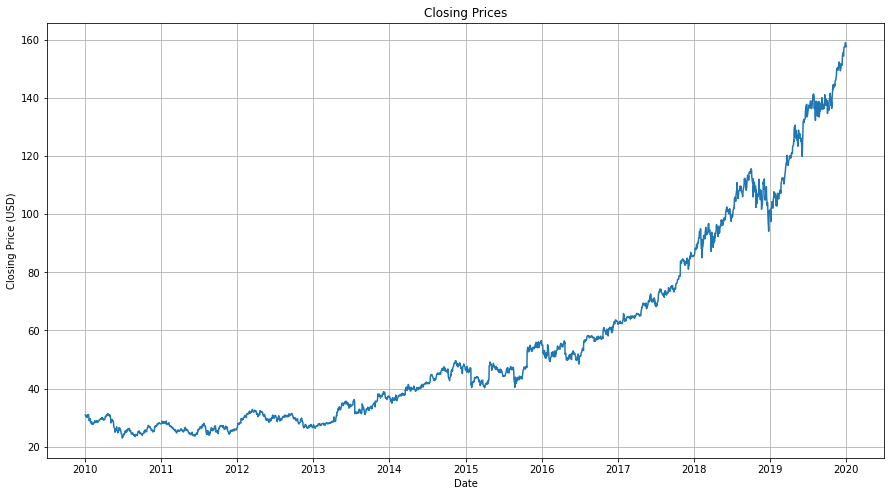

In [7]:
plt.figure(figsize = (15, 8))
plt.plot(df['Close'])
plt.title('Closing Prices')
plt.xlabel(xaxis)
plt.ylabel('Closing Price (USD)')
plt.grid(True)
# plt.savefig("ClosingPricePlot.jpg")
plt.show()

## Creating a Training Data Set

For this project we will be focusing on using the closing day market prices to train, test and make a prediction on the RNN model.

For that we make a new set by using `filter` to remove everything but the <b>Close</b> column in the data set. We then convert the set into an array and split 75% of the data to be used for training the model.

In [8]:
closeData = df.filter(['Close'])
closeArray = closeData.values
closeLength = math.ceil(len(closeArray)*0.75)

print('Number of values for training the model: ', closeLength)

Number of values for training the model:  1887


Before inputting the data into the neural network for processing, it is important to scale and normalize the data first. Here we're using the `MinMaxScaler` function to scale the closing price data set, so that it ranges inclusively from 0 and 1.

In [9]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaledData = scaler.fit_transform(closeArray)
scaleTrain = scaledData[0:closeLength, :]
scaledData

array([[0.05840383],
       [0.05847737],
       [0.05707981],
       ...,
       [1.        ],
       [0.98992269],
       [0.99073182]])

Here we are splitting the scaled data set into `Xtrain` and `ytrain`, where <b>X</b> is the independant input variable or features, and <b>y</b> is the dependent output variable or target. For these sets we `append` the user inputted `days` into `Xtrain` and the day after into `ytrain`.

In [10]:
Xtrain, ytrain = [], []

for i in range(days, len(scaleTrain)):
    Xtrain.append(scaleTrain[i - days:i, 0])
    ytrain.append(scaleTrain[i, 0])
    
    if i <= days:
        print(Xtrain)
        print(ytrain)
        print()

[array([0.05840383, 0.05847737, 0.05707981, 0.054726  , 0.05627068,
       0.05340199, 0.05193085, 0.05399044, 0.05847737, 0.05774182,
       0.05950717, 0.05575579, 0.05148952, 0.04376608, 0.04641412,
       0.04773814, 0.0489886 , 0.04523721, 0.03802869, 0.03972048,
       0.04008826, 0.04133872, 0.03552777, 0.03685178, 0.03464508,
       0.03677823, 0.03663111, 0.03758735, 0.03618977, 0.03927915,
       0.0410445 , 0.04383964, 0.04236852, 0.04207428, 0.03913203,
       0.04133872, 0.04111806, 0.04163295, 0.04420743, 0.04008826,
       0.04008826, 0.04133872, 0.0410445 , 0.04133872, 0.04258918,
       0.04383964, 0.04538433, 0.04604634, 0.04619346, 0.04678191,
       0.04869436, 0.04854726, 0.04840014, 0.0484737 , 0.05053327,
       0.04884148, 0.05148952, 0.04891504, 0.04840014, 0.04972416,
       0.04619346, 0.04523721, 0.04604634, 0.04641412, 0.04663479,
       0.05082751, 0.05391688, 0.05376976, 0.054726  , 0.05744758,
       0.05781538, 0.05634424, 0.05906584, 0.06141964, 0.0611

Converting the `Xtrain` and `ytrain` sets into arrays so they can be used when building the LSTM model. For the input variable `Xtrain`, the set must be `reshape` for the LSTM model as it expects the input data to be a 3D array.

In [11]:
Xtrain, ytrain = np.array(Xtrain), np.array(ytrain)
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))

print('Three dimensional array consisting of rows, columns and depth :', Xtrain.shape)

Three dimensional array consisting of rows, columns and depth : (1787, 100, 1)


## Building and Training the LSTM Model

Now that the preprocessed training data has been created and normalized, we can start building and compiling the LSTM model. Since LSTM is an RNN that takes sequential data, we set the model equal `Sequential()`. From there it's a matter of adding the neural network layers to the model.

For this project we have an `LSTM` layer with <b>50</b> neurons that takes in the training data as the `input_shape` and has a `return_sequence`. The next layer is also `LSTM` that contains <b>50</b> neurons but no `return_sequence` since there is no more LSTM layers moving forward. For the next 2 layers we add a `Dense` neural network layer with <b>25</b> neurons and one with only <b>1</b> neuron for the output.

In [12]:
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape=(Xtrain.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))

model.add(Dense(25))
model.add(Dense(1))

We now `compile` and train the model where it has a `loss` function for measuring the success of the training and an `optimizer` to help improve the `loss` over time. As well as, a `batch_size` and `epochs` that iterates the number of times the data passes through the neural network.

Depending on the number of iterations and data size, the time and efficiency for the model to train can vary.

In [13]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(Xtrain, ytrain, batch_size = 1, epochs = 2)

Epoch 1/2
1787/1787 [==============================] - 112s 57ms/step - loss: 4.4354e-04
Epoch 2/2
1787/1787 [==============================] - 98s 55ms/step - loss: 1.4405e-04 0s - loss: 1.4406e-0


## Creating a Testing Data Set

After creating and running the training data set through the constructed LSTM model architecture, next is testing the model and verifying how well it performs.

Similar to before, we scale the rest of the data into new test data sets `Xtest` and `ytest`. Converting `Xtest` into an array and `reshape` it so it can be an acceptable input for the LSTM model.

In [14]:
scaleTest = scaledData[closeLength - days:, :]

Xtest = []
ytest = closeArray[closeLength:, :]

for i in range(days, len(scaleTest)):
    Xtest.append(scaleTest[i - days:i, 0])
    
Xtest = np.array(Xtest)
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

print('Three dimensional array consisting of rows, columns and depth :', Xtest.shape)

Three dimensional array consisting of rows, columns and depth : (629, 100, 1)


## Plotting the Predictions Against the Original Model

Once all the training and testing data sets have been created and processed, it is simply a matter of calculating and graphing a visual representation of the training, validation and predictions data on a plot to verify the success of the LSTM model network.

Here we get the predicted model values `pred` from the `Xtest` data set and perform an `inverse_transform` so we can calculate the root mean square error (RMSE). The <b>RMSE</b> is a metric that tells us how far apart the predicted values are from the observed values. The formula is as shown,

<b>RMSE = √[Σ(Pi – Oi)*2 / n]</b>

The smaller the RMSE number, the smaller the difference there is between the predicted and actual values and the higher the accuracy of the model fit is to the data.

In [15]:
pred = model.predict(Xtest)
pred = scaler.inverse_transform(pred)

rmse = np.sqrt(np.mean(((pred - ytest)**2)))

print('Root mean square error: ', rmse)

Root mean square error:  2.1775399505310093


Plotting the training, validation and prediction of the model to see how accurately it fit the data.

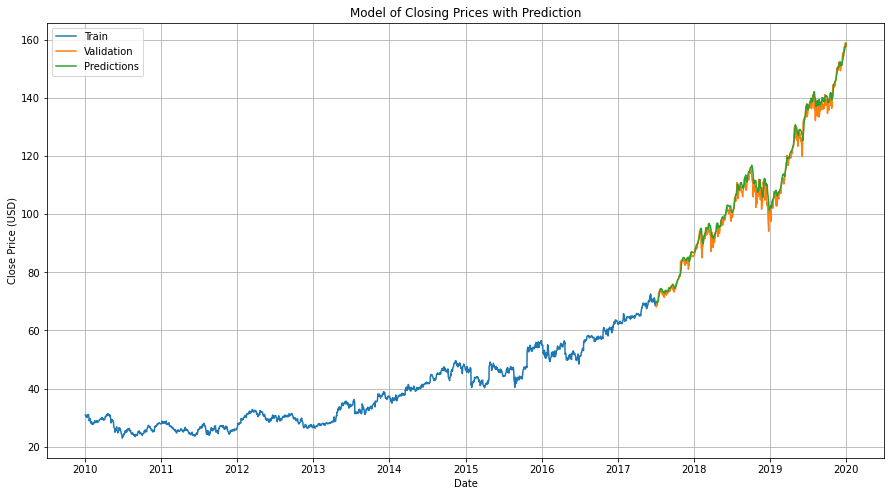

In [16]:
valid = closeData[closeLength:]
valid['Predictions'] = pred
train = closeData[:closeLength]

plt.figure(figsize = (15, 8))
plt.title('Model of Closing Prices with Prediction')
plt.xlabel(xaxis)
plt.ylabel('Close Price (USD)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'])
plt.grid(True)
# plt.savefig("ClosingPricePredPlot.jpg")
plt.show()

Displaying the validation data table to see how close the prediction values themselves were to the actual market closing prices.

In [17]:
valid

,Close,Predictions
Date,,
2017-07-03,68.169998,69.981758
2017-07-05,69.080002,69.614471
2017-07-06,68.570000,69.531029
2017-07-07,69.459999,69.434875
2017-07-10,69.980003,69.570618
...,...,...
2019-12-24,157.380005,157.029724
2019-12-26,158.669998,157.460114
2019-12-27,158.960007,158.045151


## Comparing the Predict Future Closing Price to the Actual Value

After validating the prediction model over the observed data sets and viewing how well it did, we can try to predict a future value and see how close it is to the actual stock market value for the following day after the data set range.

Here we will create new data frames of the stock market data from [Yahoo Finance](https://finance.yahoo.com/). Similar as before there are two options offered, using `DataReader` to grab data directly from the web or reading from a `.csv` file in a local path. Be sure to comment out the one that is not used.

Reading data directly from the website using `DataReader`.

In [18]:
data = web.DataReader(ticker, data_source = 'yahoo', start = startDate, end = endDate)

Reading data from the local path `.csv` file.

In [19]:
# data = pd.read_csv('MSFT.csv')

Similar to before, filtering out only the <b>Close</b> column and scale the data over the previous days that were assumed.

In [20]:
df2 = data.filter(['Close'])

numLast = df2[-days:].values
numLastScaled = scaler.transform(numLast)

Creating a new `Xtest` data set, converting it to an array and reshaping it for input into the model. From there, a predicton price is made and is `inverted_transform` from the `scaler`.

In [21]:
Xtest = []

Xtest.append(numLastScaled)
Xtest = np.array(Xtest)
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

predPrice = model.predict(Xtest)
predPrice = scaler.inverse_transform(predPrice)

print('Next day predicted price: ', predPrice)

Next day predicted price:  [[158.538]]


Getting the stock market price from the following day to compare the two values.

In [22]:
data2 = web.DataReader(ticker, data_source = 'yahoo', start = nextDay, end = nextDay)

print(data2['Close'])

Date
2020-01-02    160.619995
Name: Close, dtype: float64
